# Assignment 7

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* You can complete this assignment using either your local machine or Google Colab. Your solution for this assignment should be able to run on the <span style="color:red">FREE version</span> of Google Colab. If you find that you need to upgrade to the paid version, it indicates that there is an inefficiency in your code.
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research. 

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples. 

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

# FILL IN CODE HERE #
DATA_PATH = "./EuroSAT" # replace with your path

2024-10-22 23:03:27.655071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 1: Data ingestion

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the <span style="color:chocolate">load_data()</span> function below according to the following guidelines:
- to read label and image names: use the <span style="color:chocolate">os</span> library (in particular the <span style="color:chocolate">os.listdir()</span> and <span style="color:chocolate">os.path.join()</span> methods);
- to load an image: use the <span style="color:chocolate">load_image()</span> method (see list of imported libraries);
- to transform images to arrays: use the <span style="color:chocolate">img_to_array()</span> method (see list of imported libraries).

In [2]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)
    
    '''
    ## load images and labels
    images = []
    labels = []

    # List all files in the directory
    for label in os.listdir(path_to_data):
        label_path = os.path.join(path_to_data, label)
        
        if os.path.isdir(label_path):  # Check if it's a directory for labels
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                
                try:
                    # Load image using the provided load_img method
                    image = load_img(img_path)  # Ensure you call load_img from keras
                    # Convert the image to an array
                    image_array = img_to_array(image)
                    
                    # Append image and its corresponding label
                    images.append(image_array)
                    labels.append(label)
                    
                except Exception:  # Catch any exception, primarily for non-image files
                    continue  # Skip non-image files
                    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [3]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


---
### Step 2: Exploratory data analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

Note: It's acceptable to plot the distribution of classes before splitting your data into training, validation, and test sets. Doing so does not compromise the "blindness" of the test data. Why?

/home/jdhesi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


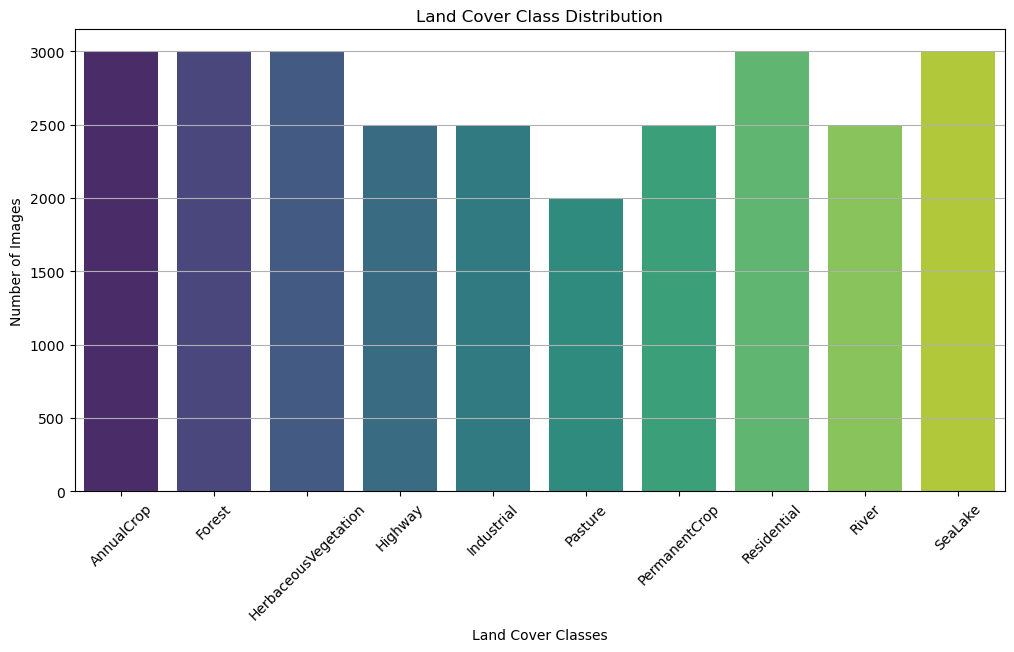

Class balance distribution: [0.11111111 0.11111111 0.11111111 0.09259259 0.09259259 0.07407407
 0.09259259 0.11111111 0.09259259 0.11111111]


In [4]:
# Count the occurrences of each class
unique_labels, counts = np.unique(labels, return_counts=True)

# Create a DataFrame for easier plotting
class_distribution = dict(zip(unique_labels, counts))

# Plotting the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')
plt.title('Land Cover Class Distribution')
plt.xlabel('Land Cover Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Check if classes are balanced
total_images = np.sum(counts)
class_balance = counts / total_images
print("Class balance distribution:", class_balance)

Comment on class balance: The classes seem to be balanced fairly well. No class is overwhelmingly larger than another.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

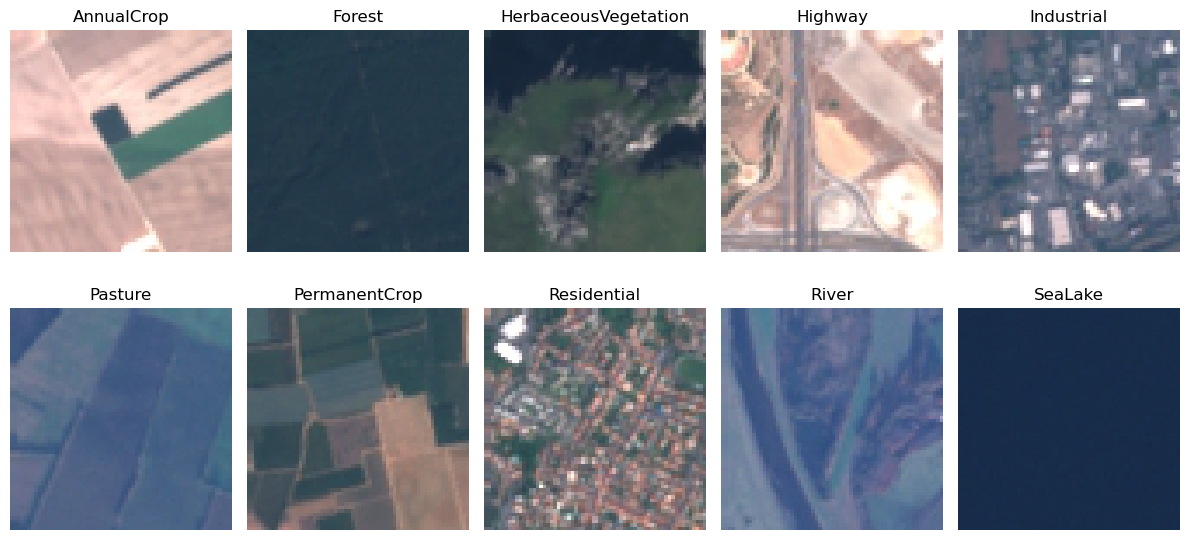

In [5]:
# Create a figure to display one image from each class
plt.figure(figsize=(12, 6))

for i, label in enumerate(unique_labels):
    # Find the index of one image belonging to the current class
    class_indices = np.where(labels == label)[0]
    
    if class_indices.size > 0:
        image_to_display = images[class_indices[0]]  # Get the first image of the class
        
        # Display the image
        plt.subplot(2, len(unique_labels)//2, i + 1)  # Adjust the subplot grid as needed
        plt.imshow(image_to_display.astype('uint8'))  # Convert array to uint8 for display
        plt.title(label)
        plt.axis('off')

plt.tight_layout()
plt.show()

Most confused land classes: The Pasture and PermanenCrop and the Forest and HerbaceousVegetation pairs seem to be classes that may easily be confused for one another.

---
### Step 3: Data preprocessing

Encode labels

In [6]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the <span style="color:chocolate">split_data()</span> function below according to the following guidelines:
- shuffle images and labels before spliting the data;
- use a 60/20/20 split.

In [7]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.
    
    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    
    images = images[indices]
    labels = labels[indices]
    
    # create data splits
    # Calculate split indices
    n_total = images.shape[0]
    n_train = int(n_total * split[0])
    n_val = int(n_total * split[1])
    
    # Create data splits
    X_train = images[:n_train]
    y_train = labels[:n_train]
    X_val = images[n_train:n_train + n_val]
    y_val = labels[n_train:n_train + n_val]
    X_test = images[n_train + n_val:]
    y_test = labels[n_train + n_val:]

    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
# define splits
split = (0.6, 0.2, 0.2)

# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation. 

<span style="color:green"> Step 1: </span> Implement the <span style="color:chocolate">data_preprocessing()</span> function below according to the following guidelines:

- Applied on training set only: 
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module);
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels;
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [9]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;
    
    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)   
    data_partition (str): "train"
    
    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    
    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3
    
    # image augmentation on training data
    if data_partition=="train":
        # adjust brightness
        X_augm = tf.image.adjust_brightness(X, delta=DELTA)

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, contrast_factor=CONTRAST_FACTOR)

        # random flip
        X_augm = tf.image.random_flip_left_right(X_augm)

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm], axis=0)

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor
        
        
    # rescale image by dividing each pixel by 255.0 
    X = X / 255.0
    return X, y

Comment on the importnace of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): Augmenting the images allows the system to experience greater variety of images and better representations of real life images which helps to improve the robustness of the model. We don't augment the test and validation data as we don't want to add bias to the model by showing similar images.

In [10]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

2024-10-22 23:04:27.826118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22 23:04:27.840768: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-10-22 23:04:27.882400: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 796262400 exceeds 10% of free system memory.


: 

Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [ ]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

---
### Step 4: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> class available in the <span style="color:chocolate">sklearn.ensemble</span> module;
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data;
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

In [ ]:
### YOUR CODE HERE #### Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=2, n_jobs=1, random_state=7, max_depth=8)

# Train the model
rf_classifier.fit(X_train_re.reshape(X_train_re.shape[0], -1), y_train_encoded)  # Flatten images for sklearn

# Make predictions
y_train_pred = rf_classifier.predict(X_train_re.reshape(X_train_re.shape[0], -1))
y_val_pred = rf_classifier.predict(X_val_re.reshape(X_val_re.shape[0], -1))

# Evaluate accuracy
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
val_accuracy = accuracy_score(y_val_encoded, y_val_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_val_encoded, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Validation Set')
plt.show()

# Comment on model performance
if train_accuracy > val_accuracy:
    print("The model may be overfitting as it performs better on the training set than on the validation set.")
elif train_accuracy < val_accuracy:
    print("The model is generalizing well, performing better on unseen validation data.")
else:
    print("The model's performance is consistent across both training and validation datasets.")

Comment on model accuracy on training vs. validation data: [YOUR ANSWER HERE]

Does the model generalize well?: [YOUR ANSWER HERE]

Comment on the classes that the model confuses the most: [YOUR ANSWER HERE]

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the training and validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). Also, the performance difference between the training and validation sets should be at most 10%. Be sure to follow these guidelines: 
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> or the <span style="color:chocolate">GradientBoostingClassifier</span> available in the <span style="color:chocolate">sklearn.ensemble</span> module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data.
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

In [ ]:
rf_clf2 = ''

# Initialize the Gradient Boosting Classifier with adjusted parameters
gb_classifier = GradientBoostingClassifier(
    n_estimators=100,       # Increased number of trees
    learning_rate=0.1,      # Reasonable learning rate
    max_depth=10,           # Increased max depth for more complex trees
    random_state=7
)

# Train the model
gb_classifier.fit(X_train_re.reshape(X_train_re.shape[0], -1), y_train_encoded)  # Flatten images for sklearn

# Make predictions
y_train_pred = gb_classifier.predict(X_train_re.reshape(X_train_re.shape[0], -1))
y_val_pred = gb_classifier.predict(X_val_re.reshape(X_val_re.shape[0], -1))

# Evaluate accuracy
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
val_accuracy = accuracy_score(y_val_encoded, y_val_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_val_encoded, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Validation Set (Improved Classifier)')
plt.show()

# Comment on model performance
if train_accuracy > val_accuracy:
    print("The model may be overfitting as it performs better on the training set than on the validation set.")
elif train_accuracy < val_accuracy:
    print("The model is generalizing well, performing better on unseen validation data.")
else:
    print("The model's performance is consistent across both training and validation datasets.")# Initialize the Gradient Boosting Classifier with adjusted parameters
gb_classifier = GradientBoostingClassifier(
    n_estimators=100,       # Increased number of trees
    learning_rate=0.1,      # Reasonable learning rate
    max_depth=10,           # Increased max depth for more complex trees
    random_state=7
)

# Train the model
gb_classifier.fit(X_train_re.reshape(X_train_re.shape[0], -1), y_train_encoded)  # Flatten images for sklearn

# Make predictions
y_train_pred = gb_classifier.predict(X_train_re.reshape(X_train_re.shape[0], -1))
y_val_pred = gb_classifier.predict(X_val_re.reshape(X_val_re.shape[0], -1))

# Evaluate accuracy
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
val_accuracy = accuracy_score(y_val_encoded, y_val_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_val_encoded, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Validation Set (Improved Classifier)')
plt.show()

# Comment on model performance
if train_accuracy > val_accuracy:
    print("The model may be overfitting as it performs better on the training set than on the validation set.")
elif train_accuracy < val_accuracy:
    print("The model is generalizing well, performing better on unseen validation data.")
else:
    print("The model's performance is consistent across both training and validation datasets.")


How your implementation is different compared to the baseline classifier: [YOUR ANSWER HERE]

Comment on training vs. validation performance relative to baseline model: [YOUR ANSWER HERE]

Comment on the classes the model confuses the most relative to the baseline: [YOUR ANSWER HERE]

---
### Step 5: Evaluation and Generalization

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the training and validation sets?

In [ ]:
### YOUR CODE HERE ###

Comment on test set accuracy vs. training vs. validation set accuracy:

---
### Step 6: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?

In [ ]:
### YOUR ANSWER HERE ###

#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?

In [ ]:
### YOUR ANSWER HERE ###

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?

In [ ]:
### YOUR CODE HERE ###